This notebook contains the pipeline to: 
* Read the CODEX tonsilitis dataset.
* Read the reference CITE-seq single-cell dataset in both protein and gene expression modalities. 
* Reduce the CITE-seq's protein and CODEX features to their intersection based on a pre-computed list of shared markers.
* Save the results as an `.h5ad` files.

Please, take the follwing steps before running this notebook:
* Download and pre-process data files in `scPortrait_manuscript/input_data/CITEseq_tonsil_reference_dataset` and `scPortrait_manuscript/input_data/CODEX_tonsil_healthy_tonsilitis` before running this notebook.
* Create a folder `generated_files` in the same directory of this notebook. 

In [1]:
import scanpy as sc
from scipy.sparse import csr_matrix
from pathlib import Path
import numpy as np
import pandas as pd

Read CITE-seq data 

In [2]:
cite_dir = Path("../../input_data/CITEseq_tonsil_reference_dataset/processed_data")
citeseq_prot = sc.read_h5ad(cite_dir / "CITEseq_protein.h5ad")
citeseq_rna = sc.read_h5ad(cite_dir / "CITEseq_rna.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


## EDA on CITE-seq

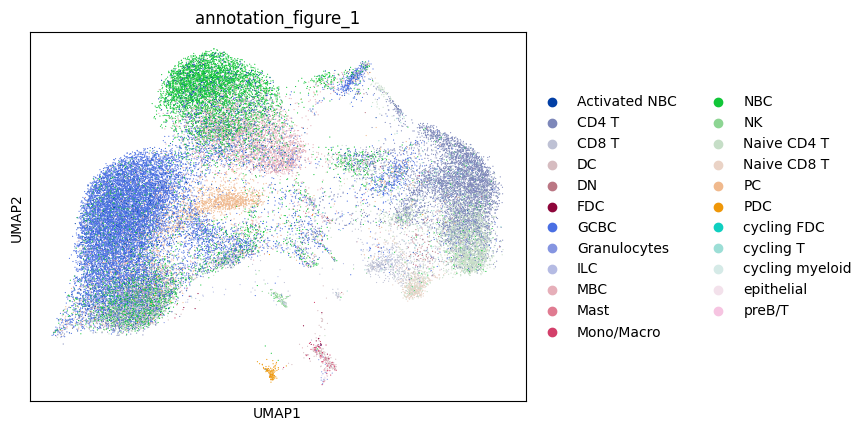

In [3]:
sc.pp.neighbors(citeseq_prot, use_rep="X_harmony_protein")
sc.tl.umap(citeseq_prot)
sc.pl.umap(citeseq_prot, color="annotation_figure_1")

Add scRNA-seq harmony to the cite-seq adata 

In [4]:
citeseq_prot.obsm["X_harmony_RNA"] = citeseq_rna.obsm["X_harmony_RNA"].copy()

In [5]:
citeseq_prot.obsm['X_harmony_RNA']

array([[ 1.66067171,  4.60854738,  0.84108148, ..., -0.41593773,
         0.84728769,  2.22269595],
       [ 2.39815427,  3.28055507, -0.64580411, ..., -0.2639632 ,
         0.11207265, -0.14819369],
       [-3.42607826,  2.14360094, -2.87407426, ...,  0.46413869,
         0.67913103,  0.58204086],
       ...,
       [ 6.2830105 , -6.94153825,  0.15688025, ...,  0.67187849,
         0.19889173, -1.71685595],
       [ 5.37549435, -6.16031339, -0.12070858, ...,  3.43597921,
         0.57471355, -1.52126325],
       [ 6.23314214, -5.71335485,  0.25630535, ...,  0.78580112,
         0.19719654,  0.41225197]])

# Map to codex

Read data frame mapping CODEX marker names to their CITE-seq counterpart. 

In [6]:
cite_to_codex_df = pd.read_csv(cite_dir / "CODEX_to_citeseq_matching.csv",
                              index_col=0)

# Remove NaN and reorder
cite_to_codex_df = cite_to_codex_df.dropna()
citeseq_prot_subset = citeseq_prot[:, cite_to_codex_df.CITEseq_feature_name]

# Final DF 
citeseq_prot_subset.var = citeseq_prot_subset.var.drop("features", axis=1)

## Now read and subset codex

In [7]:
codex_dir = Path("../../input_data/CODEX_tonsil_healthy_tonsilitis/processed_data")

adata_codex_tonsilitis = sc.read_h5ad(codex_dir / "cellfeaturization_results_tonsilitis.h5ad")

Only keep mean channels 

In [8]:
to_keep = []

for row in adata_codex_tonsilitis.var.index:
    if "mean" in row:
        to_keep.append(row)

adata_codex_tonsilitis = adata_codex_tonsilitis[:, to_keep]
adata_codex_tonsilitis.shape

(19784, 59)

Add a column with the stain name 

In [9]:
stain_names = []

for row in adata_codex_tonsilitis.var.index:
    stain = row.split("_")[0]
    stain_names.append(stain)

In [10]:
adata_codex_tonsilitis.var["stain_names"] = stain_names

/tmp/ipykernel_362023/1163731537.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_codex_tonsilitis.var["stain_names"] = stain_names


In [11]:
adata_codex_tonsilitis.var

,stain_names
DAPI_mean_nucleus,DAPI
CD45_mean_nucleus,CD45
FoxP3_mean_nucleus,FoxP3
HLA-DR_mean_nucleus,HLA-DR
CD103_mean_nucleus,CD103
CHGA_mean_nucleus,CHGA
EGFR_mean_nucleus,EGFR
CD206_mean_nucleus,CD206
GFAP_mean_nucleus,GFAP
PD-1_mean_nucleus,PD-1


In [12]:
adata_codex_tonsilitis.var["feature_name"] = adata_codex_tonsilitis.var.index
adata_codex_tonsilitis.var = adata_codex_tonsilitis.var.set_index("stain_names")

Subset to the common features with the CITE-seq dataset.  

In [13]:
adata_codex_tonsilitis = adata_codex_tonsilitis[:, cite_to_codex_df.index]

## Sanity check 

In [14]:
adata_codex_tonsilitis.var

,feature_name
stain_names,
CCR7,CCR7_mean_nucleus
CD103,CD103_mean_nucleus
CD11b,CD11b_mean_nucleus
CD11c,CD11c_mean_nucleus
CD138,CD138_mean_nucleus
CD15,CD15_mean_nucleus
CD16,CD16_mean_nucleus
CD163,CD163_mean_nucleus
CD20,CD20_mean_nucleus


In [15]:
citeseq_prot_subset.var

""
CD197-(CCR7)
CD103-(Integrin-alphaE)
CD11b
CD11c
CD138-(Syndecan-1)
CD15-(SSEA-1)
CD16
CD163
CD20
CD206-(MMR)


## Save data 

In [16]:
# Save CODEX
adata_codex_tonsilitis.write_h5ad(codex_dir / "cellfeaturization_results_tonsilitis_processed.h5ad")

In [17]:
# Save proteins 
del citeseq_prot_subset.raw
citeseq_prot_subset.write_h5ad(cite_dir / "CITEseq_protein_processed.h5ad")

# Process the CITE-seq RNA 

In [18]:
citeseq_rna_whole_genome = sc.AnnData(X=csr_matrix(citeseq_rna.raw.X.copy()), 
                                      var=citeseq_rna.raw.var.copy(), 
                                      obs=citeseq_rna.obs.copy(), 
                                      obsm=citeseq_rna.obsm.copy())

In [19]:
citeseq_rna_whole_genome.layers['X_normalized_log'] = citeseq_rna_whole_genome.X.copy()
citeseq_rna_whole_genome.layers['X_normalized_10k'] = csr_matrix(np.exp(citeseq_rna_whole_genome.X.toarray()) - 1)

In [20]:
citeseq_rna_whole_genome.write_h5ad("generated_files/CITEseq_rna_processed_full_genome.h5ad")